### Machine Learning Methods

Notebook for training, optimizing and evaluating different ML methods in forecasting E. coli levels. The methods included are LASSO, Random Forest and TPOT.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import sys
import pprint
import shap
import joblib
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import matplotlib.dates as mdates

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
from utils import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from tpot import TPOTRegressor
from astral import LocationInfo
from astral.sun import sun
from collections import OrderedDict
from functools import partial
from data import *

shap.initjs()

%matplotlib inline

In [2]:
SEED = 64

demo_run = False
log_scale_microbial_feats = True

model_name = 'default'
if log_scale_microbial_feats:
    model_name = 'log_scaled_microbial_feats'
    
data_folder = '../data/cleanedFiles/'
img_path = '../data/output/' + model_name + '/'
target_label = 'ecoli_lab_LAE'

train_start = '2012-04-03' # 5.5 Years of Training
train_end = '2017-10-30'
test_start = '2017-10-31' # 2 Years of Testing
test_end = '2019-10-30'

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if not os.path.exists(img_path + 'LASSO'):
    os.makedirs(img_path + 'LASSO')
    
if not os.path.exists(img_path + 'RF'):
    os.makedirs(img_path + 'RF')
    
if not os.path.exists(img_path + 'TPOT'):
    os.makedirs(img_path + 'TPOT')


In [3]:
# Load Data.

df = read_ecoli_lab('ecoli_LAE', log_scale_microbial_feats)
df = df.join(read_ecoli_lab('ecoli_GA', log_scale_microbial_feats))

df = df.join(read_ecoli_colifast('colifast_LAE'))
df = df.join(read_ecoli_colifast('colifast_GA'))

df = df.join(read_precipitation('precipitation_GBG', False))
df = df.join(read_precipitation('precipitation_VB', True))
df = df.join(read_precipitation('precipitation_KR', True))

df = df.join(read_water_temp('waterTemp_LAE'))

df = df.join(read_flow_rate('flowrate_LE'))
df = df.join(read_flow_rate('flowrate_GG'))

#df = df.join(read_water_level('waterLevel_TOR'))

df = df.join(read_turbidity('turb_LAE'))

df = df.join(read_coliforms('coliforms_LAE', log_scale_microbial_feats))
df = df.join(read_coliforms('coliforms_GA', log_scale_microbial_feats))

display(df)

,ecoli_lab_LAE,ecoli_lab_GA,ecoli_colifast_LAE_1st,ecoli_colifast_LAE_2nd,ecoli_colifast_GA_1st,ecoli_colifast_GA_2nd,precipitation_GBG,precipitation_VB,precipitation_KR,waterTemp_LAE,flowrate_LE,flowrate_GG,turb_LAE,coliforms_LAE,coliforms_GA
2012-01-02,5.398163,5.252273,2.0,3.0,NaN,NaN,0.5,3.7,2.5,4.8,880,220,7.1,6.478510,6.647688
2012-01-03,NaN,NaN,3.0,3.0,NaN,NaN,21.3,16.9,28.0,NaN,853,213,NaN,NaN,NaN
2012-01-04,5.707110,6.255750,4.0,1.0,NaN,NaN,7.0,0.5,6.4,4.9,785,196,8.5,6.660575,7.244942
2012-01-05,5.739793,6.274762,5.0,6.0,NaN,NaN,0.2,0.1,0.0,4.7,882,221,31.2,7.313887,7.313887
2012-01-06,NaN,NaN,5.0,5.0,NaN,NaN,0.0,0.0,0.0,NaN,879,220,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,5.017280,4.875197,2.0,1.0,2.0,2.0,NaN,NaN,NaN,4.6,591,148,5.3,5.739793,5.739793
2019-12-27,5.081404,NaN,1.0,1.0,1.0,2.0,NaN,NaN,NaN,4.2,655,164,5.4,5.968708,NaN
2019-12-28,NaN,NaN,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,847,212,NaN,NaN,NaN
2019-12-29,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,829,207,NaN,NaN,NaN


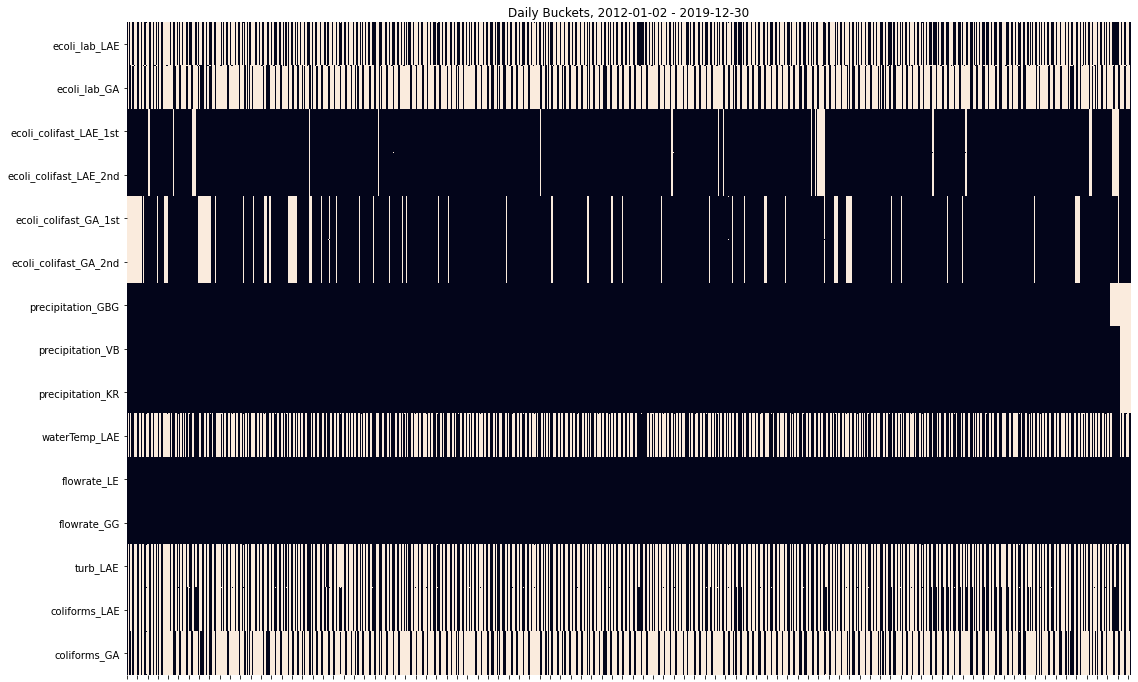

In [4]:
# Check NaN

plt.figure(figsize=(18,12), facecolor='w')
ax = sns.heatmap(df.transpose().isnull(), cbar=False)
ax.set(xticklabels=[])
plt.title('Daily Buckets, ' + df.index[0].strftime('%Y-%m-%d') + ' - ' + df.index[-1].strftime('%Y-%m-%d'))
plt.savefig(img_path + 'missing_values.png', bbox_inches='tight', transparent=False)
plt.show()

In [5]:
# Feature Engineering

df_feat = df.copy()
drop_features = []

display(df_feat.loc[(df_feat.index >= '2019-10-01') & (df_feat.index <= '2019-10-15')])

# E. coli Lab
def get_irregular_lag_features(df_tmp, label, n_shift=3, n_days_dummy=True):

    label_values = [None for i in range(n_shift)]
    label_dates = [None for i in range(n_shift)]
    for ds_idx in df_tmp.index.values:

        if not np.isnan(df_tmp.loc[ds_idx, target_label]):
            for i in range(1, n_shift+1):
                if label_values[n_shift-i] != None:
                    df_tmp.loc[ds_idx, label + '_lag' + str(i) + 'O'] = label_values[n_shift-i]
                    df_tmp.loc[ds_idx, label + '_lag' + str(i) + 'O_nDaysDummy'] = (ds_idx - label_dates[n_shift-i]) / np.timedelta64(1, 'D')
                else:
                    df_tmp.loc[ds_idx, label + '_lag' + str(i) + 'O'] = None
                    df_tmp.loc[ds_idx, label + '_lag' + str(i) + 'O_nDaysDummy'] = None

        if not np.isnan(df_tmp.loc[ds_idx, label]):

            label_values.append(df_tmp.loc[ds_idx, label])
            label_dates.append(ds_idx)

            if (len(label_values) > n_shift) and (len(label_dates) > n_shift):
                label_values.pop(0)
                label_dates.pop(0)
                
    if n_days_dummy == False:
        df_tmp = df_tmp.drop([label + '_lag' + str(i) + 'O_nDaysDummy' for i in range(1, n_shift+1)], axis=1)
    
    return df_tmp

df_feat = get_irregular_lag_features(df_feat, 'ecoli_lab_LAE', 3, False)
df_feat = get_irregular_lag_features(df_feat, 'ecoli_lab_GA', 3, False)
drop_features.append('ecoli_lab_GA')

# E. coli Colifast
sep_labels = [
    'ecoli_colifast_LAE_1st',
    'ecoli_colifast_LAE_2nd',
    'ecoli_colifast_GA_1st',
    'ecoli_colifast_GA_2nd',
]
df_feat[sep_labels[0]] = df_feat[sep_labels[0]].fillna(df_feat[sep_labels[2]])
df_feat[sep_labels[2]] = df_feat[sep_labels[2]].fillna(df_feat[sep_labels[0]])
df_feat[sep_labels[1]] = df_feat[sep_labels[1]].fillna(df_feat[sep_labels[3]])
df_feat[sep_labels[3]] = df_feat[sep_labels[3]].fillna(df_feat[sep_labels[1]])

labels = [
    'ecoli_colifast_LAE',
    'ecoli_colifast_GA'
]
n_shifts = 10
for label in labels:
    for i in range(1, n_shifts+1):

        suffix = '_2nd'
        if (i % 2) == 0:
            suffix = '_1st'

        df_feat[label + '_lag' + str(i) + 'O'] = df_feat[label + suffix].shift(int(np.ceil(i/2))).fillna(method='ffill')

drop_features.extend(sep_labels)

# Precipitation
labels = [
    'precipitation_GBG',
    'precipitation_VB',
    'precipitation_KR'
]
n_shifts = 6
#n_days_consec_threshold = 10
for label in labels:

    #n_days_consec_wet_label = label + '_nDaysConsecWet'
    #df_feat[n_days_consec_wet_label] = (df_feat[label] > 0.0)
    #df_feat[n_days_consec_wet_label] = df_feat[n_days_consec_wet_label].cumsum() - df_feat[n_days_consec_wet_label].cumsum().where(~df_feat[n_days_consec_wet_label]).ffill().fillna(0)
    #df_feat[n_days_consec_wet_label] = df_feat[n_days_consec_wet_label].shift(1).astype(float)
    #df_feat.loc[df_feat[n_days_consec_wet_label] > n_days_consec_threshold, n_days_consec_wet_label] = n_days_consec_threshold

    #n_days_consec_dry_label = label + '_nDaysConsecDry'
    #df_feat[n_days_consec_dry_label] = (df_feat[label] == 0.0)
    #df_feat[n_days_consec_dry_label] = df_feat[n_days_consec_dry_label].cumsum() - df_feat[n_days_consec_dry_label].cumsum().where(~df_feat[n_days_consec_dry_label]).ffill().fillna(0)
    #df_feat[n_days_consec_dry_label] = df_feat[n_days_consec_dry_label].shift(1).astype(float)
    #df_feat.loc[df_feat[n_days_consec_dry_label] > n_days_consec_threshold, n_days_consec_dry_label] = n_days_consec_threshold
    #df_feat[n_days_consec_dry_label] = -1.0 * df_feat[n_days_consec_dry_label]

    #n_days_consec_label = label + '_nDaysConsecDryWet'
    #df_feat[n_days_consec_label] = df_feat[n_days_consec_wet_label] + df_feat[n_days_consec_dry_label]
    #df_feat = df_feat.drop([n_days_consec_wet_label, n_days_consec_dry_label], axis=1)

    for i in range(1, n_shifts+1):
        df_feat[label + '_lag' + str(i) + 'D'] = df_feat[label].shift(i)

drop_features.extend(labels)
            
# Water Temp
df_feat = get_irregular_lag_features(df_feat, 'waterTemp_LAE', 1, False)
drop_features.append('waterTemp_LAE')

# Flow Rate
labels = [
    'flowrate_LE',
    'flowrate_GG',
]
n_shifts = 5
for label in labels:
    for i in range(1, n_shifts+1):
        df_feat[label + '_lag' + str(i) + 'D'] = df_feat[label].shift(i)

drop_features.extend(labels)
    
# Turbidity
df_feat = get_irregular_lag_features(df_feat, 'turb_LAE', 3, False)
drop_features.append('turb_LAE')

# Coliforms
df_feat = get_irregular_lag_features(df_feat, 'coliforms_LAE', 3, False)
df_feat = get_irregular_lag_features(df_feat, 'coliforms_GA', 3, False)
drop_features.append('coliforms_LAE')
drop_features.append('coliforms_GA')

display(df_feat.loc[(df_feat.index >= '2019-10-01') & (df_feat.index <= '2019-10-15')])

,ecoli_lab_LAE,ecoli_lab_GA,ecoli_colifast_LAE_1st,ecoli_colifast_LAE_2nd,ecoli_colifast_GA_1st,ecoli_colifast_GA_2nd,precipitation_GBG,precipitation_VB,precipitation_KR,waterTemp_LAE,flowrate_LE,flowrate_GG,turb_LAE,coliforms_LAE,coliforms_GA
2019-10-01,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0,0.0,NaN,480,152,NaN,NaN,NaN
2019-10-02,6.018593,NaN,5.0,3.0,2.0,5.0,0.1,8.1,0.0,12.2,408,151,5.8,8.556606,NaN
2019-10-03,NaN,5.802118,3.0,1.0,4.0,3.0,0.8,0.2,3.0,NaN,433,153,NaN,NaN,7.090910
2019-10-04,5.638355,NaN,4.0,3.0,2.0,2.0,0.2,0.0,0.0,11.2,430,151,4.7,7.438972,NaN
2019-10-05,NaN,NaN,1.0,1.0,5.0,4.0,0.0,0.1,0.0,NaN,427,152,NaN,NaN,NaN
2019-10-06,NaN,NaN,6.0,3.0,2.0,1.0,0.0,0.0,0.0,NaN,459,156,NaN,NaN,NaN
2019-10-07,4.709530,4.330733,6.0,2.0,2.0,4.0,0.0,1.8,0.8,9.3,655,186,6.2,6.216606,5.638355
2019-10-08,1.791759,NaN,NaN,NaN,2.0,3.0,1.4,9.4,7.0,9.6,498,165,NaN,5.739793,NaN
2019-10-09,4.465908,4.595120,1.0,1.0,2.0,3.0,0.4,0.6,5.2,9.2,537,158,5.5,5.916202,6.758095
2019-10-10,NaN,4.875197,1.0,3.0,1.0,4.0,2.2,0.8,8.1,NaN,545,165,NaN,NaN,6.538140


,ecoli_lab_LAE,ecoli_lab_GA,ecoli_colifast_LAE_1st,ecoli_colifast_LAE_2nd,ecoli_colifast_GA_1st,ecoli_colifast_GA_2nd,precipitation_GBG,precipitation_VB,precipitation_KR,waterTemp_LAE,...,flowrate_GG_lag5D,turb_LAE_lag1O,turb_LAE_lag2O,turb_LAE_lag3O,coliforms_LAE_lag1O,coliforms_LAE_lag2O,coliforms_LAE_lag3O,coliforms_GA_lag1O,coliforms_GA_lag2O,coliforms_GA_lag3O
2019-10-01,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0,0.0,NaN,...,216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-02,6.018593,NaN,5.0,3.0,2.0,5.0,0.1,8.1,0.0,12.2,...,151.0,11.0,8.5,6.7,9.680406,5.673323,5.968708,9.472782,6.196444,5.888878
2019-10-03,NaN,5.802118,3.0,1.0,4.0,3.0,0.8,0.2,3.0,NaN,...,147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-04,5.638355,NaN,4.0,3.0,2.0,2.0,0.2,0.0,0.0,11.2,...,148.0,5.8,11.0,8.5,8.556606,9.680406,5.673323,7.090910,9.472782,6.196444
2019-10-05,NaN,NaN,1.0,1.0,5.0,4.0,0.0,0.1,0.0,NaN,...,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-06,NaN,NaN,6.0,3.0,2.0,1.0,0.0,0.0,0.0,NaN,...,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-07,4.709530,4.330733,6.0,2.0,2.0,4.0,0.0,1.8,0.8,9.3,...,151.0,4.7,5.8,11.0,7.438972,8.556606,9.680406,7.090910,9.472782,6.196444
2019-10-08,1.791759,NaN,2.0,3.0,2.0,3.0,1.4,9.4,7.0,9.6,...,153.0,6.2,4.7,5.8,6.216606,7.438972,8.556606,5.638355,7.090910,9.472782
2019-10-09,4.465908,4.595120,1.0,1.0,2.0,3.0,0.4,0.6,5.2,9.2,...,151.0,6.2,4.7,5.8,5.739793,6.216606,7.438972,5.638355,7.090910,9.472782
2019-10-10,NaN,4.875197,1.0,3.0,1.0,4.0,2.2,0.8,8.1,NaN,...,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Split and Prepare

print(df_feat.shape)
print(df_feat.isnull().any(axis=1).sum())
print(df_feat.isnull().sum())
print('')

df_feat = df_feat.loc[(df_feat.index >= train_start) & (df_feat.index <= test_end)]
df_feat = df_feat[~df_feat[target_label].isnull()]

df_feat = df_feat.drop(drop_features, axis=1)

print(df_feat.shape)
print(df_feat.isnull().any(axis=1).sum())
print(df_feat.isnull().sum())
print('')

display(df_feat.describe())

df_train = df_feat.loc[(df_feat.index >= train_start) & (df_feat.index <= train_end)]
df_test = df_feat.loc[(df_feat.index >= test_start) & (df_feat.index <= test_end)]

train_dates = df_train.index
test_dates = df_test.index

X_train = df_train.loc[:, df_train.columns != target_label].values
y_train = df_train.loc[:, df_train.columns == target_label].values.ravel()

X_test = df_test.loc[:, df_train.columns != target_label].values
y_test = df_test.loc[:, df_train.columns == target_label].values.ravel()



(2920, 79)
2391
ecoli_lab_LAE             1630
ecoli_lab_GA              1996
ecoli_colifast_LAE_1st      10
ecoli_colifast_LAE_2nd      10
ecoli_colifast_GA_1st       10
                          ... 
coliforms_LAE_lag2O       1632
coliforms_LAE_lag3O       1633
coliforms_GA_lag1O        1631
coliforms_GA_lag2O        1632
coliforms_GA_lag3O        1633
Length: 79, dtype: int64

(1213, 65)
0
ecoli_lab_LAE          0
ecoli_lab_LAE_lag1O    0
ecoli_lab_LAE_lag2O    0
ecoli_lab_LAE_lag3O    0
ecoli_lab_GA_lag1O     0
                      ..
coliforms_LAE_lag2O    0
coliforms_LAE_lag3O    0
coliforms_GA_lag1O     0
coliforms_GA_lag2O     0
coliforms_GA_lag3O     0
Length: 65, dtype: int64



,ecoli_lab_LAE,ecoli_lab_LAE_lag1O,ecoli_lab_LAE_lag2O,ecoli_lab_LAE_lag3O,ecoli_lab_GA_lag1O,ecoli_lab_GA_lag2O,ecoli_lab_GA_lag3O,ecoli_colifast_LAE_lag1O,ecoli_colifast_LAE_lag2O,ecoli_colifast_LAE_lag3O,...,flowrate_GG_lag5D,turb_LAE_lag1O,turb_LAE_lag2O,turb_LAE_lag3O,coliforms_LAE_lag1O,coliforms_LAE_lag2O,coliforms_LAE_lag3O,coliforms_GA_lag1O,coliforms_GA_lag2O,coliforms_GA_lag3O
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,4.411766,4.410095,4.406385,4.405335,4.524965,4.473577,4.470922,2.099753,2.158285,2.083265,...,166.240725,7.566529,7.524073,7.521105,6.250157,6.240650,6.237713,6.263885,6.230848,6.223293
std,1.105603,1.105126,1.104319,1.105008,1.130251,1.162351,1.147893,1.340820,1.358754,1.311472,...,30.463766,4.838134,4.815910,4.761685,1.029004,1.024906,1.029907,1.102709,1.113320,1.108412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,77.000000,2.400000,2.400000,2.400000,2.564949,2.564949,2.564949,1.609438,1.609438,1.609438
25%,3.737670,3.737670,3.737670,3.737670,3.737670,3.737670,3.737670,1.000000,1.000000,1.000000,...,145.000000,4.700000,4.600000,4.700000,5.564520,5.564520,5.564520,5.525453,5.525453,5.484797
50%,4.454347,4.454347,4.454347,4.454347,4.574711,4.465908,4.465908,2.000000,2.000000,2.000000,...,152.000000,6.200000,6.200000,6.200000,6.089045,6.089045,6.089045,6.154858,6.133398,6.133398
75%,5.141664,5.141664,5.141664,5.141664,5.252273,5.252273,5.252273,3.000000,3.000000,3.000000,...,184.000000,8.600000,8.600000,8.500000,6.867974,6.867974,6.836259,6.898715,6.836259,6.867974
max,7.170888,7.170888,7.170888,7.170888,7.378384,7.378384,7.378384,6.000000,6.000000,6.000000,...,279.000000,49.000000,49.000000,49.000000,9.903538,9.903538,9.903538,9.680406,9.680406,9.680406


In [7]:
# Print variables to file.

with open(img_path + 'variables.json', 'w') as outfile:
    json.dump(
        {
            'target': target_label,
            'predictors': df_train.loc[:, df_train.columns != target_label].columns.tolist()
        },
        outfile,
        indent=4
    )

In [8]:
# Run LASSO Optimization.

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

model = Pipeline(
    [
        ('scaler', None),
        ('pca', None),
        ('model', TransformedTargetRegressor())
    ]
)

lasso = Lasso(
    max_iter=200000,
    tol=1e-3,
    random_state=SEED
)

n_alphas = 1000
alpha_min = 0.0001
alpha_max = 10
alphas = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num=n_alphas)
fit_intercept = [True, False]
scalers = [PowerTransformer(), StandardScaler()]
pca = [
    #PCA(n_components=3),
    #PCA(n_components=int(X_train.shape[1]/2)),
    #PCA(n_components=X_train.shape[1]),
    'passthrough'
]

if demo_run:
    fit_intercept = [True]
    scalers = [StandardScaler()]
    pca = ['passthrough']

params = [
    {
        'scaler': scalers,
        'pca': pca,
        'model__regressor': [lasso],
        'model__func': [None],
        'model__inverse_func': [None],
        'model__regressor__alpha': alphas,
        'model__regressor__fit_intercept': fit_intercept
    }
]

if not log_scale_microbial_feats:
    params.append({
        'scaler': scalers,
        'pca': pca,
        'model__regressor': [lasso],
        'model__func': [np.log1p],
        'model__inverse_func': [lambda x: np.exp(x)-1.0],
        'model__regressor__alpha': alphas,
        'model__regressor__fit_intercept': fit_intercept
    })

lasso_gs_cv = GridSearchCV(
    model,
    params,
    cv=tscv,
    scoring=['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error'],
    return_train_score=True,
    refit='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

lasso_gs_cv.fit(X_train, y_train)
lasso_y_test = lasso_gs_cv.best_estimator_.predict(X_test)
lasso_y_train = lasso_gs_cv.best_estimator_.predict(X_train)

cv_scores = OrderedDict({
    'Avg Train MSE': lasso_gs_cv.cv_results_['mean_train_neg_mean_squared_error'][lasso_gs_cv.best_index_],
    'Avg Test MSE': lasso_gs_cv.cv_results_['mean_test_neg_mean_squared_error'][lasso_gs_cv.best_index_],
    'Train MSE': [],
    'Test MSE': [],
    'Avg Train R²': lasso_gs_cv.cv_results_['mean_train_r2'][lasso_gs_cv.best_index_],
    'Avg Test R²': lasso_gs_cv.cv_results_['mean_test_r2'][lasso_gs_cv.best_index_],
    'Train R²': [],
    'Test R²': [],
    'Avg Train MAE': lasso_gs_cv.cv_results_['mean_train_neg_mean_absolute_error'][lasso_gs_cv.best_index_],
    'Avg Test MAE': lasso_gs_cv.cv_results_['mean_test_neg_mean_absolute_error'][lasso_gs_cv.best_index_],
    'Train MAE': [],
    'Test MAE': [],
})

for i in range(n_splits):
    cv_scores['Train MSE'].append(lasso_gs_cv.cv_results_['split' + str(i) + '_train_neg_mean_squared_error'][lasso_gs_cv.best_index_])
    cv_scores['Test MSE'].append(lasso_gs_cv.cv_results_['split' + str(i) + '_test_neg_mean_squared_error'][lasso_gs_cv.best_index_])
    cv_scores['Train R²'].append(lasso_gs_cv.cv_results_['split' + str(i) + '_train_r2'][lasso_gs_cv.best_index_])
    cv_scores['Test R²'].append(lasso_gs_cv.cv_results_['split' + str(i) + '_test_r2'][lasso_gs_cv.best_index_])
    cv_scores['Train MAE'].append(lasso_gs_cv.cv_results_['split' + str(i) + '_train_neg_mean_absolute_error'][lasso_gs_cv.best_index_])
    cv_scores['Test MAE'].append(lasso_gs_cv.cv_results_['split' + str(i) + '_test_neg_mean_absolute_error'][lasso_gs_cv.best_index_])

best_params = lasso_gs_cv.best_params_.copy()

print('')
pprint.pprint(best_params)
pprint.pprint(cv_scores)

if demo_run == False:
    for key in best_params:
        if type(best_params[key]) not in [int, bool, np.float64, str] and best_params[key] != None:
            best_params[key] = str(best_params[key])

    with open(img_path + 'LASSO/best_params.json', 'w') as outfile:
        json.dump(best_params, outfile, indent=4)

    with open(img_path + 'LASSO/cv_scores.json', 'w') as outfile:
        json.dump(cv_scores, outfile, indent=4)

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2808 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5408 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8408 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 11808 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 15608 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 19808 tasks      | elapsed:  7.2min



{'model__func': None,
 'model__inverse_func': None,
 'model__regressor': Lasso(alpha=0.025258200269627846, max_iter=200000, random_state=64, tol=0.001),
 'model__regressor__alpha': 0.025258200269627846,
 'model__regressor__fit_intercept': True,
 'pca': 'passthrough',
 'scaler': StandardScaler()}
OrderedDict([('Avg Train MSE', -0.37679221721784306),
             ('Avg Test MSE', -0.5552802022744769),
             ('Train MSE',
              [-0.28683117634981475,
               -0.3741745548010085,
               -0.37759824306392026,
               -0.3862998608544851,
               -0.4590572510199868]),
             ('Test MSE',
              [-0.705441792970339,
               -0.40283319329679196,
               -0.4371236519067408,
               -0.7925034618635295,
               -0.4384989113349834]),
             ('Avg Train R²', 0.6408789839047424),
             ('Avg Test R²', 0.5718972813760388),
             ('Train R²',
              [0.6374470918059036,
               

[Parallel(n_jobs=-1)]: Done 20000 out of 20000 | elapsed:  7.3min finished


In [9]:
# Plots MAE for Bins.
'''
y_test, lasso_y_test = np.array(y_test), np.array(lasso_y_test)

df_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])

mask = np.argwhere(y_test < 50)
performance = obtain_performance('<50', y_test[mask].flatten(), lasso_y_test[mask].flatten())
performance['Nr of Observations'] = y_test[mask].flatten().shape[0]
df_eval = df_eval.append(performance, ignore_index=True)

mask = np.argwhere((y_test >= 50) & (y_test < 100))
performance = obtain_performance('50-100', y_test[mask].flatten(), lasso_y_test[mask].flatten())
performance['Nr of Observations'] = y_test[mask].flatten().shape[0]
df_eval = df_eval.append(performance, ignore_index=True)

mask = np.argwhere((y_test >= 100) & (y_test < 200))
performance = obtain_performance('100-200', y_test[mask].flatten(), lasso_y_test[mask].flatten())
performance['Nr of Observations'] = y_test[mask].flatten().shape[0]
df_eval = df_eval.append(performance, ignore_index=True)

mask = np.argwhere((y_test >= 200) & (y_test < 400))
performance = obtain_performance('200-400', y_test[mask].flatten(), lasso_y_test[mask].flatten())
performance['Nr of Observations'] = y_test[mask].flatten().shape[0]
df_eval = df_eval.append(performance, ignore_index=True)

mask = np.argwhere(y_test > 400)
performance = obtain_performance('>400', y_test[mask].flatten(), lasso_y_test[mask].flatten())
performance['Nr of Observations'] = y_test[mask].flatten().shape[0]
df_eval = df_eval.append(performance, ignore_index=True)

df_eval = df_eval.rename({'Model': 'Bin'}, axis=1)
display(df_eval)


ax = df_eval.plot.bar(x='Bin', y='MAE', rot=0, figsize=(8,6), legend=False)
plt.ylabel('MAE')
plt.show()

ax = df_eval.plot.bar(x='Bin', y='Nr of Observations', rot=0, figsize=(8,6), legend=False, color='green')
plt.ylabel('Nr of Observations')
plt.show()
'''

"\ny_test, lasso_y_test = np.array(y_test), np.array(lasso_y_test)\n\ndf_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])\n\nmask = np.argwhere(y_test < 50)\nperformance = obtain_performance('<50', y_test[mask].flatten(), lasso_y_test[mask].flatten())\nperformance['Nr of Observations'] = y_test[mask].flatten().shape[0]\ndf_eval = df_eval.append(performance, ignore_index=True)\n\nmask = np.argwhere((y_test >= 50) & (y_test < 100))\nperformance = obtain_performance('50-100', y_test[mask].flatten(), lasso_y_test[mask].flatten())\nperformance['Nr of Observations'] = y_test[mask].flatten().shape[0]\ndf_eval = df_eval.append(performance, ignore_index=True)\n\nmask = np.argwhere((y_test >= 100) & (y_test < 200))\nperformance = obtain_performance('100-200', y_test[mask].flatten(), lasso_y_test[mask].flatten())\nperformance['Nr of Observations'] = y_test[mask].flatten().shape[0]\ndf_eval = df_eval.append(performance, ignore_index=True)\n\nmask = np.argwhere((y_test >= 200) &

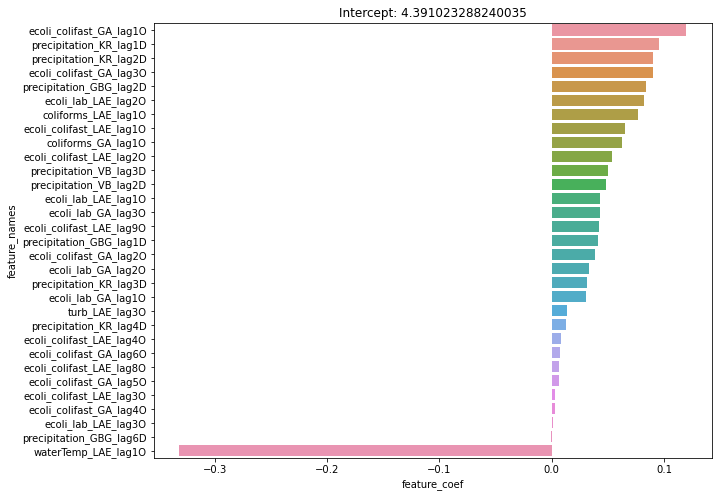

In [10]:
# LASSO Coefficients.

df_viz = pd.DataFrame({
    'feature_names': df_train.iloc[:, 1:].columns,
    'feature_coef': lasso_gs_cv.best_estimator_['model'].regressor_.coef_
})
df_viz = df_viz.sort_values(by=['feature_coef'], ascending=False, inplace=False).reset_index()

df_viz.to_csv(
    img_path + 'LASSO/coefficients.csv',
    index=False
)

# Plot all Non-Zero
df_viz = df_viz[df_viz['feature_coef'] != 0]

plt.figure(figsize=(10,8), facecolor='w')
sns.set_color_codes("pastel")
sns.barplot(x='feature_coef', y='feature_names', data=df_viz, orient='h')
plt.title('Intercept: ' + str(lasso_gs_cv.best_estimator_['model'].regressor_.intercept_))
if demo_run == False:
    plt.savefig(img_path + 'LASSO/coefficients.png', bbox_inches='tight', transparent=False, dpi=200)
plt.show()

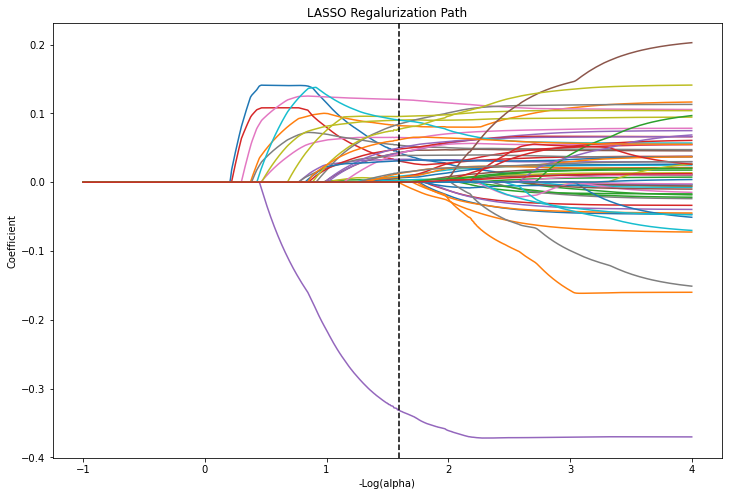

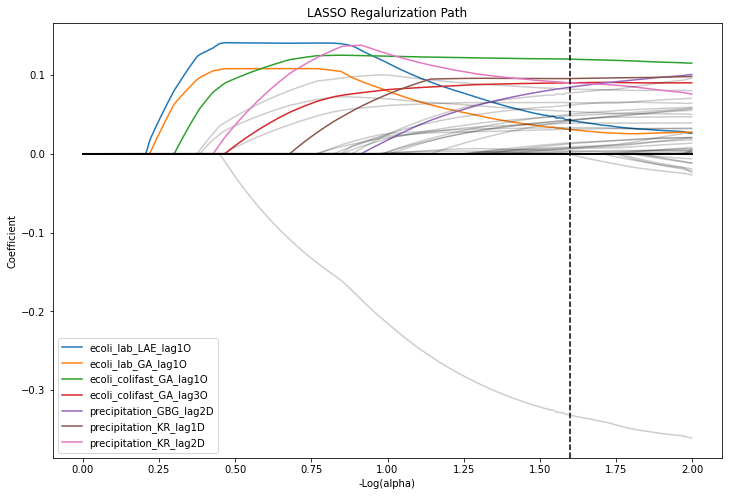

In [11]:
# Visualize LASSO Regularization Path

if lasso_gs_cv.best_params_['scaler']:
    X_train_lasso_path = lasso_gs_cv.best_params_['scaler'].fit_transform(X_train)
else:
    X_train_lasso_path = X_train
    
if lasso_gs_cv.best_params_['model__func']:
    y_train_lasso_path = lasso_gs_cv.best_params_['model__func'](y_train)
else:
    y_train_lasso_path = y_train

# LASSO Path
alphas_, coefs, _ = lasso_path(
    X_train_lasso_path,
    y_train_lasso_path,
    alphas=alphas,
    fit_intercept=best_params['model__regressor__fit_intercept'],
    max_iter=200000,
    tol=1e-3,
    random_state=SEED
)

neg_log_alphas_ = -np.log10(alphas_)

plt.figure(figsize=(12,8), facecolor='w')
for coef in coefs:
    plt.plot(neg_log_alphas_, coef)
    
plt.axvline(x=-np.log10(lasso_gs_cv.best_params_['model__regressor__alpha']), color='black', linestyle='dashed')
plt.ylabel('Coefficient')
plt.xlabel('-Log(alpha)')
plt.title('LASSO Regalurization Path')
if demo_run == False:
    plt.savefig(img_path + 'LASSO/lasso_path.png', bbox_inches='tight', transparent=False, dpi=200)
plt.show()

mask = (neg_log_alphas_ > 0.0) & (neg_log_alphas_ < 2.0)
labeled_features = df_viz.loc[:4, 'feature_names'].tolist()
additional_features = [
    'ecoli_lab_LAE_lag1O',
    'ecoli_lab_GA_lag1O',
]
for label in additional_features:
    if label not in labeled_features:
        labeled_features.append(label)

plt.figure(figsize=(12,8), facecolor='w')
for coef, feature in zip(coefs, df_train.iloc[:, 1:].columns):
    if feature in labeled_features:
        plt.plot(neg_log_alphas_[mask], coef[mask], label=feature)
    else:   
        plt.plot(neg_log_alphas_[mask], coef[mask], color='black', alpha=0.2)
    
plt.axvline(x=-np.log10(lasso_gs_cv.best_params_['model__regressor__alpha']), color='black', linestyle='dashed')
plt.legend(loc='lower left')
plt.ylabel('Coefficient')
plt.xlabel('-Log(alpha)')
plt.title('LASSO Regalurization Path')
if demo_run == False:
    plt.savefig(img_path + 'LASSO/lasso_path_zoom.png', bbox_inches='tight', transparent=False, dpi=200)
plt.show()

In [12]:
# Run Random Forest Optimization.

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

model = Pipeline(
    [
        ('transform', None),
        ('model', TransformedTargetRegressor())
    ]
)

rf = RandomForestRegressor(random_state=SEED)

estimators = [200]
max_depth = [3, 4, 5, 6]
min_samples_split = [4, 8, 12, 16, 24]
min_samples_leaf = [2, 4, 8, 12, 16, 24]
max_features = ['sqrt', 0.25, 0.5, 0.75]
bootstrap = [True, False]
transform = [
    #Pipeline([
    #    ('scaler', StandardScaler()),
    #    ('pca', PCA(n_components=3))
    #]),
    #Pipeline([
    #    ('scaler', StandardScaler()),
    #    ('pca', PCA(n_components=int(X_train.shape[1]/2)))
    #]),
    #Pipeline([
    #    ('scaler', StandardScaler()),
    #    ('pca', PCA(n_components=X_train.shape[1]))
    #]),
    'passthrough'
]

if demo_run:
    estimators = [200]
    max_depth = [5]
    min_samples_split = [5]
    min_samples_leaf = [2]
    max_features = ['sqrt']
    transform = ['passthrough']
    bootstrap = [True]

params = [
    {
        'transform': transform,
        'model__regressor': [rf],
        'model__func': [None],
        'model__inverse_func': [None],
        'model__regressor__n_estimators': estimators,
        'model__regressor__max_depth': max_depth,
        'model__regressor__min_samples_split': min_samples_split,
        'model__regressor__min_samples_leaf': min_samples_leaf,
        'model__regressor__max_features': max_features,
        'model__regressor__bootstrap': bootstrap
    }
]

if not log_scale_microbial_feats:
    params.append({
        'transform': transform,
        'model__regressor': [rf],
        'model__func': [np.log1p],
        'model__inverse_func': [lambda x: np.exp(x)-1.0],
        'model__regressor__n_estimators': estimators,
        'model__regressor__max_depth': max_depth,
        'model__regressor__min_samples_split': min_samples_split,
        'model__regressor__min_samples_leaf': min_samples_leaf,
        'model__regressor__max_features': max_features,
        'model__regressor__bootstrap': bootstrap
    })

rf_gs_cv = GridSearchCV(
    model,
    params,
    cv=tscv,
    scoring=['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error'],
    return_train_score=True,
    refit='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

rf_gs_cv.fit(X_train, y_train)
rf_y_test = rf_gs_cv.best_estimator_.predict(X_test)
rf_y_train = rf_gs_cv.best_estimator_.predict(X_train)

cv_scores = OrderedDict({
    'Avg Train MSE': rf_gs_cv.cv_results_['mean_train_neg_mean_squared_error'][rf_gs_cv.best_index_],
    'Avg Test MSE': rf_gs_cv.cv_results_['mean_test_neg_mean_squared_error'][rf_gs_cv.best_index_],
    'Train MSE': [],
    'Test MSE': [],
    'Avg Train R²': rf_gs_cv.cv_results_['mean_train_r2'][rf_gs_cv.best_index_],
    'Avg Test R²': rf_gs_cv.cv_results_['mean_test_r2'][rf_gs_cv.best_index_],
    'Train R²': [],
    'Test R²': [],
    'Avg Train MAE': rf_gs_cv.cv_results_['mean_train_neg_mean_absolute_error'][rf_gs_cv.best_index_],
    'Avg Test MAE': rf_gs_cv.cv_results_['mean_test_neg_mean_absolute_error'][rf_gs_cv.best_index_],
    'Train MAE': [],
    'Test MAE': [],
})

for i in range(n_splits):
    cv_scores['Train MSE'].append(rf_gs_cv.cv_results_['split' + str(i) + '_train_neg_mean_squared_error'][rf_gs_cv.best_index_])
    cv_scores['Test MSE'].append(rf_gs_cv.cv_results_['split' + str(i) + '_test_neg_mean_squared_error'][rf_gs_cv.best_index_])
    cv_scores['Train R²'].append(rf_gs_cv.cv_results_['split' + str(i) + '_train_r2'][rf_gs_cv.best_index_])
    cv_scores['Test R²'].append(rf_gs_cv.cv_results_['split' + str(i) + '_test_r2'][rf_gs_cv.best_index_])
    cv_scores['Train MAE'].append(rf_gs_cv.cv_results_['split' + str(i) + '_train_neg_mean_absolute_error'][rf_gs_cv.best_index_])
    cv_scores['Test MAE'].append(rf_gs_cv.cv_results_['split' + str(i) + '_test_neg_mean_absolute_error'][rf_gs_cv.best_index_])

    
best_params = rf_gs_cv.best_params_

print('')
pprint.pprint(best_params)
pprint.pprint(cv_scores)

if demo_run == False:
    for key in best_params:
        if type(best_params[key]) not in [int, bool, np.float64, str] and best_params[key] != None:
            best_params[key] = str(best_params[key])

    with open(img_path + 'RF/best_params.json', 'w') as outfile:
        json.dump(best_params, outfile, indent=4)

    with open(img_path + 'RF/cv_scores.json', 'w') as outfile:
        json.dump(cv_scores, outfile, indent=4)


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  9.3min finished



{'model__func': None,
 'model__inverse_func': None,
 'model__regressor': RandomForestRegressor(max_depth=6, max_features=0.75, min_samples_leaf=2,
                      min_samples_split=8, n_estimators=200, random_state=64),
 'model__regressor__bootstrap': True,
 'model__regressor__max_depth': 6,
 'model__regressor__max_features': 0.75,
 'model__regressor__min_samples_leaf': 2,
 'model__regressor__min_samples_split': 8,
 'model__regressor__n_estimators': 200,
 'transform': 'passthrough'}
OrderedDict([('Avg Train MSE', -0.1894378967231805),
             ('Avg Test MSE', -0.6149242506715608),
             ('Train MSE',
              [-0.11319402835759916,
               -0.17181024990578242,
               -0.18438868141589557,
               -0.2095162755812682,
               -0.2682802483553572]),
             ('Test MSE',
              [-0.8367821031706736,
               -0.42515723139900885,
               -0.49758759426404797,
               -0.80327542645037,
               -0.

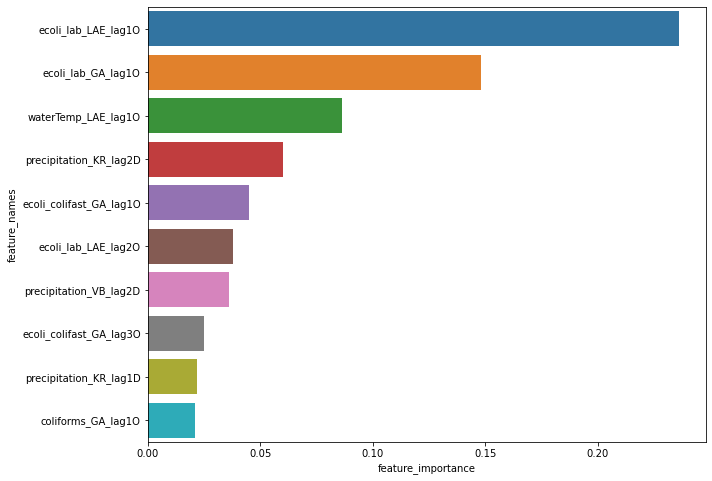

In [13]:
# Visualize Random Forest Feature Importance.

df_viz = pd.DataFrame({
    'feature_names': df_train.iloc[:, 1:].columns,
    'feature_importance': rf_gs_cv.best_estimator_['model'].regressor_.feature_importances_
})
df_viz.sort_values(by=['feature_importance'], ascending=False, inplace=True)

df_viz.to_csv(
    img_path + 'RF/feature_importance.csv',
    index=False
)

plt.figure(figsize=(10,8), facecolor='w')
sns.set_color_codes("pastel")
sns.barplot(x='feature_importance', y='feature_names', data=df_viz.iloc[:10], orient='h')
if demo_run == False:
    plt.savefig(img_path + 'RF/feature_importance.png', bbox_inches='tight', transparent=False)
plt.show()

In [14]:
# Run TPOT Optimization.

n_generations = 100
population_size = 100
if demo_run:
    n_generations = 1
    population_size = 5

tscv = TimeSeriesSplit(n_splits=5)

tpot_model = TPOTRegressor(
    generations=n_generations,
    population_size=population_size,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbosity=2,
    n_jobs=-1,
    random_state=SEED
)

tpot_model.fit(X_train, y_train)

print('')
print(tpot_model.fitted_pipeline_)

tpot_y_test = tpot_model.predict(X_test)
tpot_y_train = tpot_model.predict(X_train)

if demo_run == False:
    tpot_model.export(img_path + 'TPOT/tpot_model.py')


Version 0.11.5 of tpot is outdated. Version 0.11.6 was released 3 days ago.



Generation 1 - Current best internal CV score: -0.555325411117664
Generation 2 - Current best internal CV score: -0.555325411117664
Generation 3 - Current best internal CV score: -0.555325411117664
Generation 4 - Current best internal CV score: -0.555325411117664
Generation 5 - Current best internal CV score: -0.555325411117664
Generation 6 - Current best internal CV score: -0.5495414743059783
Generation 7 - Current best internal CV score: -0.5495414743059783
Generation 8 - Current best internal CV score: -0.5495414743059783
Generation 9 - Current best internal CV score: -0.5495414743059783
Generation 10 - Current best internal CV score: -0.5495414743059783
Generation 11 - Current best internal CV score: -0.5495414743059783
Generation 12 - Current best internal CV score: -0.5495414743059783
Generation 13 - Current best internal CV score: -0.5491285466510674
Generation 14 - Current best internal CV score: -0.5491285466510674
Generation 15 - Current best internal CV score: -0.5451808245

In [15]:
# Save Observations and Predictions.

if demo_run == False:
    pd.DataFrame({
        'ds': train_dates,
        'observation': y_train,
        'prediction': lasso_y_train
    }).to_csv(
        img_path + 'LASSO/train_predictions.csv',
        index=False
    )

    pd.DataFrame({
        'ds': test_dates,
        'observation': y_test,
        'prediction': lasso_y_test
    }).to_csv(
        img_path + 'LASSO/test_predictions.csv',
        index=False
    )

    pd.DataFrame({
        'ds': train_dates,
        'observation': y_train,
        'prediction': rf_y_train
    }).to_csv(
        img_path + 'RF/train_predictions.csv',
        index=False
    )

    pd.DataFrame({
        'ds': test_dates,
        'observation': y_test,
        'prediction': rf_y_test
    }).to_csv(
        img_path + 'RF/test_predictions.csv',
        index=False
    )

    pd.DataFrame({
        'ds': train_dates,
        'observation': y_train,
        'prediction': tpot_y_train
    }).to_csv(
        img_path + 'TPOT/train_predictions.csv',
        index=False
    )

    pd.DataFrame({
        'ds': test_dates,
        'observation': y_test,
        'prediction': tpot_y_test
    }).to_csv(
        img_path + 'TPOT/test_predictions.csv',
        index=False
    )

In [16]:
# Show Performance.

print('\nTrain Metrics')

lasso_performance = obtain_performance('LASSO', y_train, lasso_y_train)
rf_performance = obtain_performance('RF', y_train, rf_y_train)
tpot_performance = obtain_performance('TPOT', y_train, tpot_y_train)

df_train_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_train_eval = df_train_eval.append(lasso_performance, ignore_index=True)
df_train_eval = df_train_eval.append(rf_performance, ignore_index=True)
df_train_eval = df_train_eval.append(tpot_performance, ignore_index=True)

df_train_eval.to_csv(
    img_path + 'ml_train_metrics.csv',
    index=False
)

s = df_train_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

if demo_run == False:
    dfi.export(s, img_path + 'ml_train_metrics.png')


print('\nTest Metrics')

lasso_performance = obtain_performance('LASSO', y_test, lasso_y_test)
rf_performance = obtain_performance('RF', y_test, rf_y_test)
tpot_performance = obtain_performance('TPOT', y_test, tpot_y_test)

df_test_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_test_eval = df_test_eval.append(lasso_performance, ignore_index=True)
df_test_eval = df_test_eval.append(rf_performance, ignore_index=True)
df_test_eval = df_test_eval.append(tpot_performance, ignore_index=True)

df_test_eval.to_csv(
    img_path + 'ml_test_metrics.csv',
    index=False
)

s = df_test_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

if demo_run == False:
    dfi.export(s, img_path + 'ml_test_metrics.png')



Train Metrics


Model,MAE,SMAPE,RMSE,R2
LASSO,0.503752,12.913011,0.670227,0.634406
RF,0.392379,10.453205,0.525079,0.775610
TPOT,0.507563,12.991206,0.680435,0.623184



Test Metrics


Model,MAE,SMAPE,RMSE,R2
LASSO,0.508718,12.307041,0.659409,0.637241
RF,0.543171,12.974161,0.700189,0.590986
TPOT,0.526162,12.698219,0.687668,0.605483


In [17]:
# Evaluate Q4-Q1

months_to_evaluate = [10, 11, 12, 1, 2, 3]

train_mask = [True if date.month in months_to_evaluate else False for date in train_dates]
lasso_performance = obtain_performance('LASSO', y_train[train_mask], lasso_y_train[train_mask])
rf_performance = obtain_performance('RF', y_train[train_mask], rf_y_train[train_mask])
tpot_performance = obtain_performance('TPOT', y_train[train_mask], tpot_y_train[train_mask])

df_train_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_train_eval = df_train_eval.append(lasso_performance, ignore_index=True)
df_train_eval = df_train_eval.append(rf_performance, ignore_index=True)
df_train_eval = df_train_eval.append(tpot_performance, ignore_index=True)

df_train_eval.to_csv(
    img_path + 'ml_train_metrics_Q4-Q1.csv',
    index=False
)

s = df_train_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

if demo_run == False:
    dfi.export(s, img_path + 'ml_train_metrics_Q4-Q1.png')


test_mask = [True if date.month in months_to_evaluate else False for date in test_dates]
lasso_performance = obtain_performance('LASSO', y_test[test_mask], lasso_y_test[test_mask])
rf_performance = obtain_performance('RF', y_test[test_mask], rf_y_test[test_mask])
tpot_performance = obtain_performance('TPOT', y_test[test_mask], tpot_y_test[test_mask])

df_test_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_test_eval = df_test_eval.append(lasso_performance, ignore_index=True)
df_test_eval = df_test_eval.append(rf_performance, ignore_index=True)
df_test_eval = df_test_eval.append(tpot_performance, ignore_index=True)

df_test_eval.to_csv(
    img_path + 'ml_test_metrics_Q4-Q1.csv',
    index=False
)

s = df_test_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

if demo_run == False:
    dfi.export(s, img_path + 'ml_test_metrics_Q4-Q1.png')

Model,MAE,SMAPE,RMSE,R2
LASSO,0.451179,9.683982,0.578859,0.586841
RF,0.333889,7.246670,0.432605,0.769244
TPOT,0.443957,9.516041,0.582258,0.581976


Model,MAE,SMAPE,RMSE,R2
LASSO,0.484761,10.147384,0.619163,0.485086
RF,0.526343,10.982182,0.660668,0.413738
TPOT,0.502896,10.450758,0.658073,0.418334


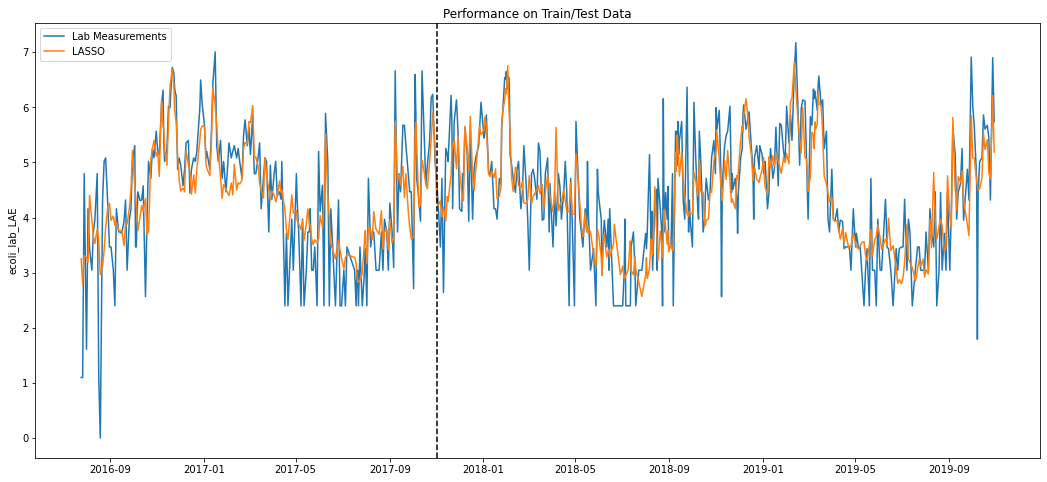

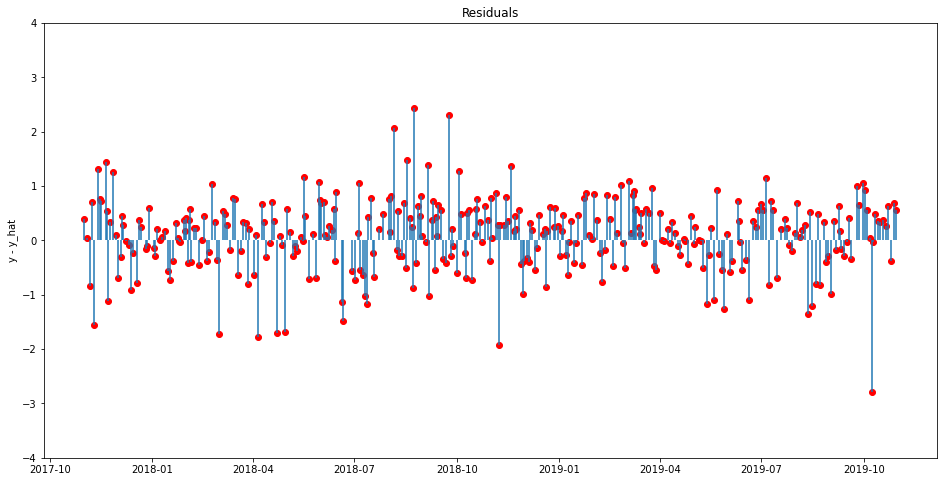

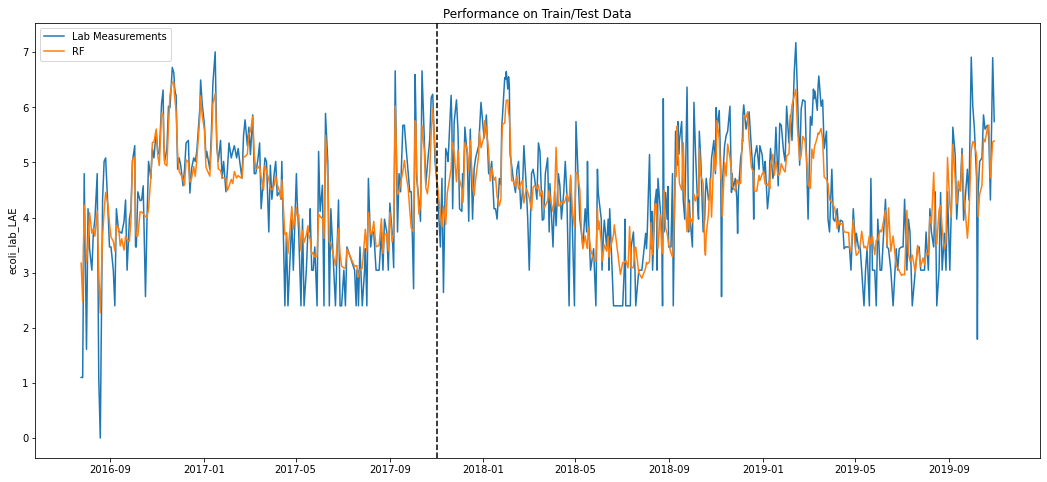

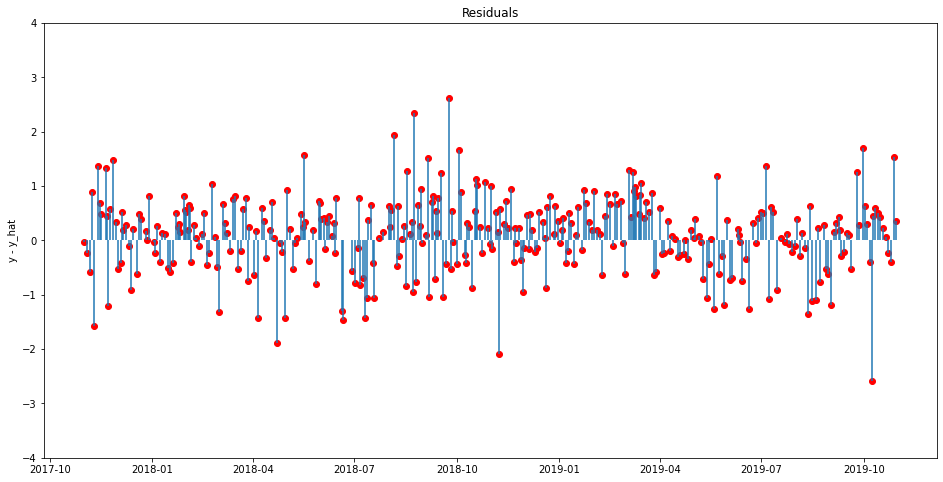

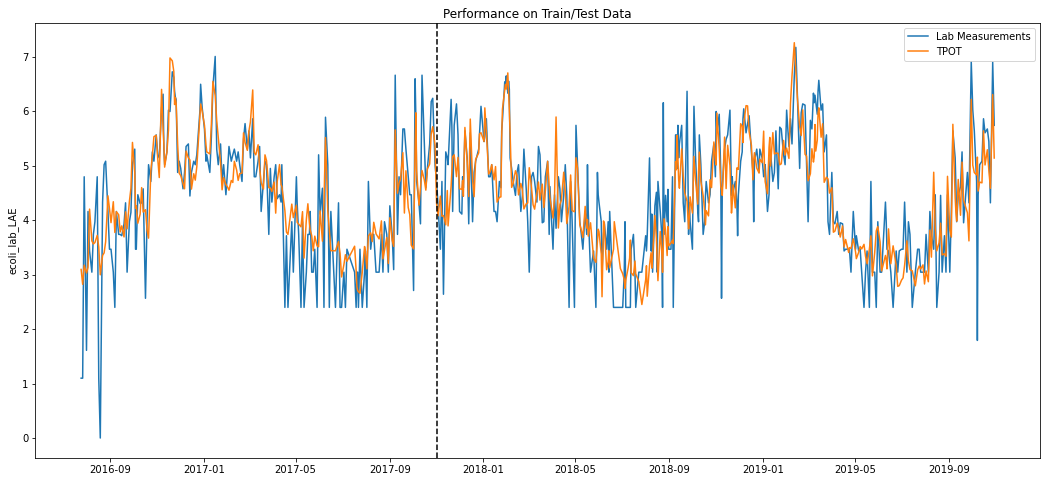

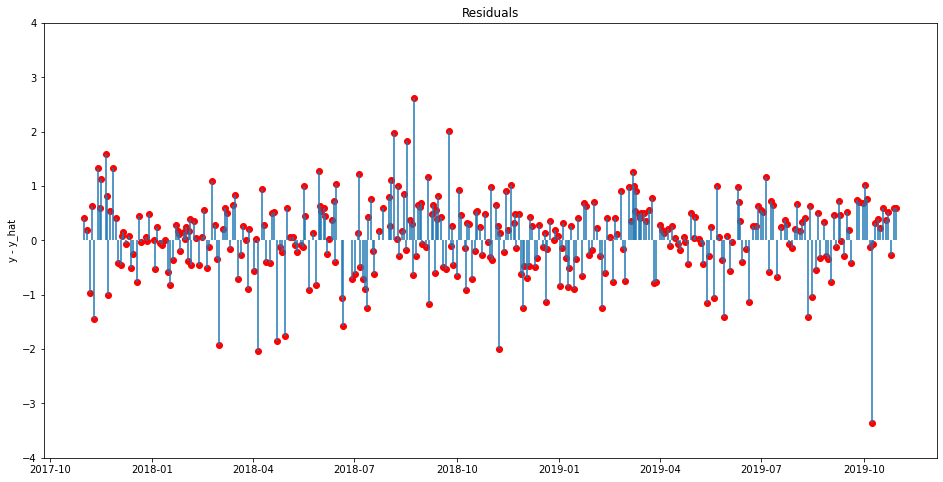

In [18]:
# Plot Performance.

n_train_dates = 200

y_min = -600
y_max = 1000
if log_scale_microbial_feats:
    y_min = -4
    y_max = 4

plt.figure(figsize=(18, 8), facecolor='w')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(y_train[-n_train_dates:], y_test), label='Lab Measurements')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(lasso_y_train[-n_train_dates:], lasso_y_test), label='LASSO')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.ylabel(target_label)
plt.title('Performance on Train/Test Data')
plt.legend()
if demo_run == False:
    plt.savefig(img_path + 'LASSO/test_plot.png', bbox_inches='tight', transparent=False, dpi=300)
plt.show()

plt.figure(figsize=(16, 8), facecolor='w')
plt.scatter(test_dates, y_test-lasso_y_test, c='red')
plt.vlines(test_dates, 0.0, y_test-lasso_y_test)
plt.ylabel('y - y_hat')
plt.ylim(y_min, y_max)
plt.title('Residuals')
if demo_run == False:
    plt.savefig(img_path + 'LASSO/test_plot_residuals.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(18, 8), facecolor='w')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(y_train[-n_train_dates:], y_test), label='Lab Measurements')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(rf_y_train[-n_train_dates:], rf_y_test), label='RF')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.ylabel(target_label)
plt.title('Performance on Train/Test Data')
plt.legend()
if demo_run == False:
    plt.savefig(img_path + 'RF/test_plot.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(16, 8), facecolor='w')
plt.scatter(test_dates, y_test-rf_y_test, c='red')
plt.vlines(test_dates, 0.0, y_test-rf_y_test)
plt.ylabel('y - y_hat')
plt.ylim(y_min, y_max)
plt.title('Residuals')
if demo_run == False:
    plt.savefig(img_path + 'RF/test_plot_residuals.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(18, 8), facecolor='w')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(y_train[-n_train_dates:], y_test), label='Lab Measurements')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(tpot_y_train[-n_train_dates:], tpot_y_test), label='TPOT')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.ylabel(target_label)
plt.title('Performance on Train/Test Data')
plt.legend()
if demo_run == False:
    plt.savefig(img_path + 'TPOT/test_plot.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(16, 8), facecolor='w')
plt.scatter(test_dates, y_test-tpot_y_test, c='red')
plt.vlines(test_dates, 0.0, y_test-tpot_y_test)
plt.ylabel('y - y_hat')
plt.ylim(y_min, y_max)
plt.title('Residuals')
if demo_run == False:
    plt.savefig(img_path + 'TPOT/test_plot_residuals.png', bbox_inches='tight', transparent=False)
plt.show()

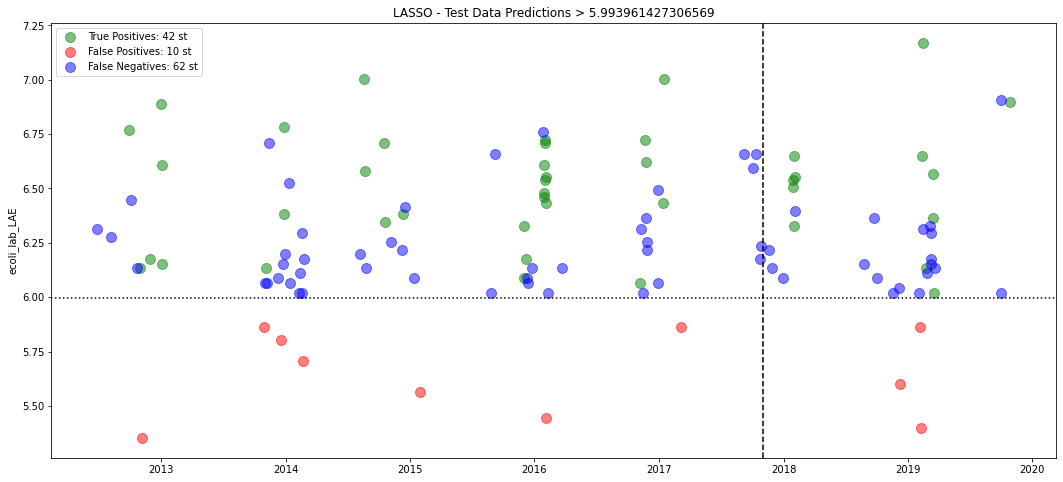

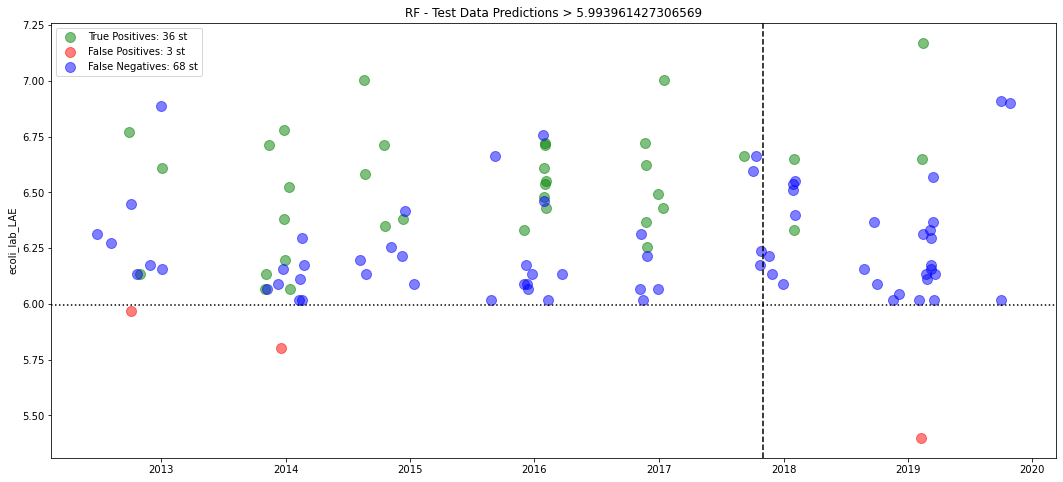

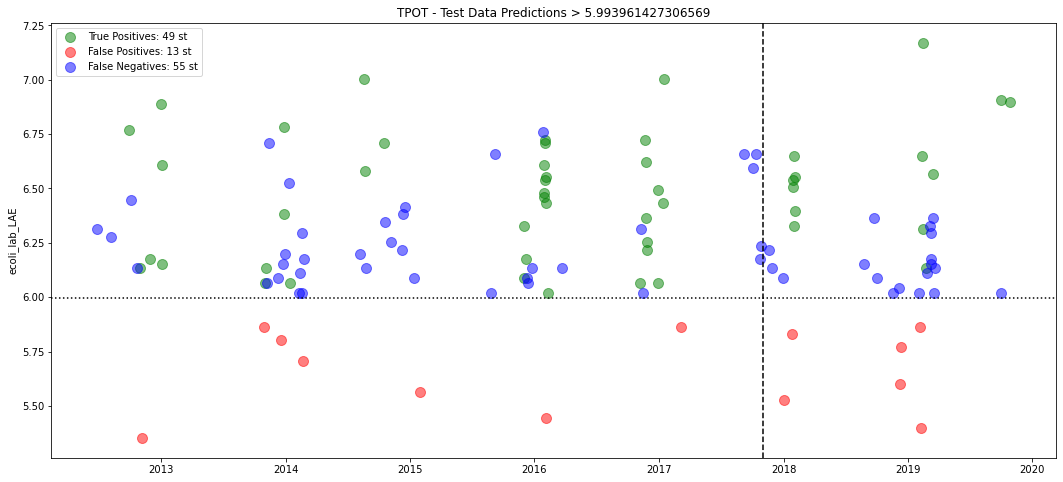

In [19]:
# Plot Performance on High Levels.

threshold = 400
if log_scale_microbial_feats:
    threshold = np.log1p(threshold)

y_merged = np.append(y_train, y_test)
y_merged_lasso = np.append(lasso_y_train, lasso_y_test)
merged_dates = np.append(train_dates, test_dates)

tp_mask = (y_merged > threshold) * (y_merged_lasso > threshold)
fp_mask = (y_merged < threshold) * (y_merged_lasso > threshold)
fn_mask = (y_merged > threshold) * (y_merged_lasso < threshold)

plt.figure(figsize=(18, 8), facecolor='w')
plt.scatter(merged_dates[tp_mask], y_merged[tp_mask], color='green', s=100, alpha=0.5, label='True Positives: ' + str(sum(tp_mask)) + ' st')
plt.scatter(merged_dates[fp_mask], y_merged[fp_mask], color='red', s=100, alpha=0.5, label='False Positives: ' + str(sum(fp_mask)) + ' st')
plt.scatter(merged_dates[fn_mask], y_merged[fn_mask], color='blue', s=100, alpha=0.5, label='False Negatives: ' + str(sum(fn_mask)) + ' st')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.axhline(y=threshold, color='black', linestyle='dotted')
plt.ylabel(target_label)
plt.title('LASSO - Test Data Predictions > ' + str(threshold))
plt.legend()
if demo_run == False:
    plt.savefig(img_path + 'LASSO/threshold_plot.png', bbox_inches='tight', transparent=False)
plt.show()

y_merged = np.append(y_train, y_test)
y_merged_rf = np.append(rf_y_train, rf_y_test)
merged_dates = np.append(train_dates, test_dates)

tp_mask = (y_merged > threshold) * (y_merged_rf > threshold)
fp_mask = (y_merged < threshold) * (y_merged_rf > threshold)
fn_mask = (y_merged > threshold) * (y_merged_rf < threshold)

plt.figure(figsize=(18, 8), facecolor='w')
plt.scatter(merged_dates[tp_mask], y_merged[tp_mask], color='green', s=100, alpha=0.5, label='True Positives: ' + str(sum(tp_mask)) + ' st')
plt.scatter(merged_dates[fp_mask], y_merged[fp_mask], color='red', s=100, alpha=0.5, label='False Positives: ' + str(sum(fp_mask)) + ' st')
plt.scatter(merged_dates[fn_mask], y_merged[fn_mask], color='blue', s=100, alpha=0.5, label='False Negatives: ' + str(sum(fn_mask)) + ' st')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.axhline(y=threshold, color='black', linestyle='dotted')
plt.ylabel(target_label)
plt.title('RF - Test Data Predictions > ' + str(threshold))
plt.legend()
if demo_run == False:
    plt.savefig(img_path + 'RF/threshold_plot.png', bbox_inches='tight', transparent=False)
plt.show()

y_merged = np.append(y_train, y_test)
y_merged_tpot = np.append(tpot_y_train, tpot_y_test)
merged_dates = np.append(train_dates, test_dates)

tp_mask = (y_merged > threshold) * (y_merged_tpot > threshold)
fp_mask = (y_merged < threshold) * (y_merged_tpot > threshold)
fn_mask = (y_merged > threshold) * (y_merged_tpot < threshold)

plt.figure(figsize=(18, 8), facecolor='w')
plt.scatter(merged_dates[tp_mask], y_merged[tp_mask], color='green', s=100, alpha=0.5, label='True Positives: ' + str(sum(tp_mask)) + ' st')
plt.scatter(merged_dates[fp_mask], y_merged[fp_mask], color='red', s=100, alpha=0.5, label='False Positives: ' + str(sum(fp_mask)) + ' st')
plt.scatter(merged_dates[fn_mask], y_merged[fn_mask], color='blue', s=100, alpha=0.5, label='False Negatives: ' + str(sum(fn_mask)) + ' st')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.axhline(y=threshold, color='black', linestyle='dotted')
plt.ylabel(target_label)
plt.title('TPOT - Test Data Predictions > ' + str(threshold))
plt.legend()
if demo_run == False:
    plt.savefig(img_path + 'TPOT/threshold_plot.png', bbox_inches='tight', transparent=False)
plt.show()


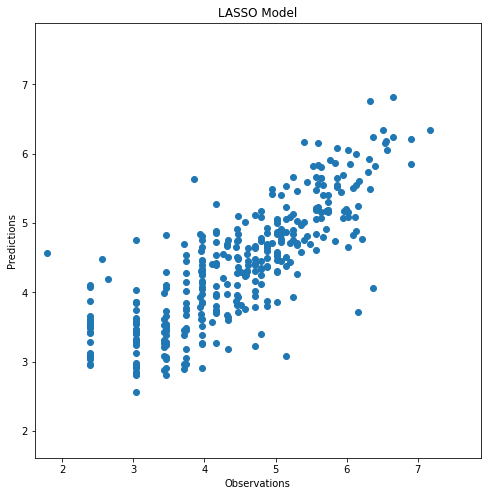

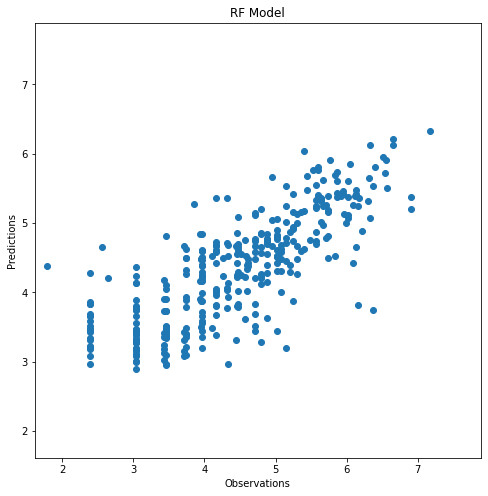

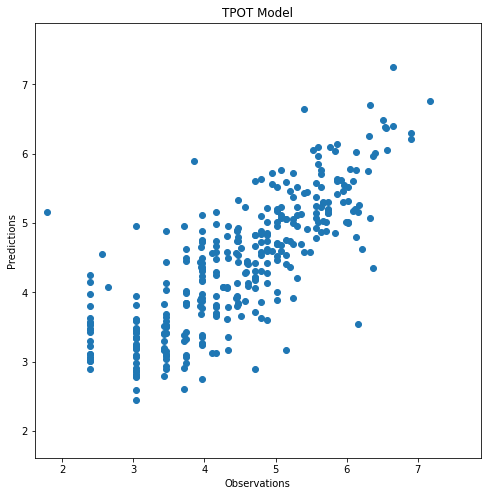

In [20]:
# Scatter Plots.

_axis_min = min(y_test) - 0.1*min(y_test)
_axis_max = max(y_test) + 0.1*max(y_test)

if log_scale_microbial_feats:
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, lasso_y_test)
    plt.xlim(_axis_min, _axis_max)
    plt.ylim(_axis_min, _axis_max)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('LASSO Model')
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, rf_y_test)
    plt.xlim(_axis_min, _axis_max)
    plt.ylim(_axis_min, _axis_max)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('RF Model')
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, tpot_y_test)
    plt.xlim(_axis_min, _axis_max)
    plt.ylim(_axis_min, _axis_max)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('TPOT Model')
    plt.show()
    
else:

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, lasso_y_test)
    plt.xlim(_axis_min, _axis_max)
    plt.ylim(_axis_min, _axis_max)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('LASSO Model')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, lasso_y_test)
    plt.xlim(0, 400)
    plt.ylim(0, 400)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('LASSO Model')
    plt.show()

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, rf_y_test)
    plt.xlim(_axis_min, _axis_max)
    plt.ylim(_axis_min, _axis_max)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('RF Model')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, rf_y_test)
    plt.xlim(0, 400)
    plt.ylim(0, 400)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('RF Model')
    plt.show()

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, tpot_y_test)
    plt.xlim(_axis_min, _axis_max)
    plt.ylim(_axis_min, _axis_max)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('TPOT Model')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, tpot_y_test)
    plt.xlim(0, 400)
    plt.ylim(0, 400)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('TPOT Model')
    plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


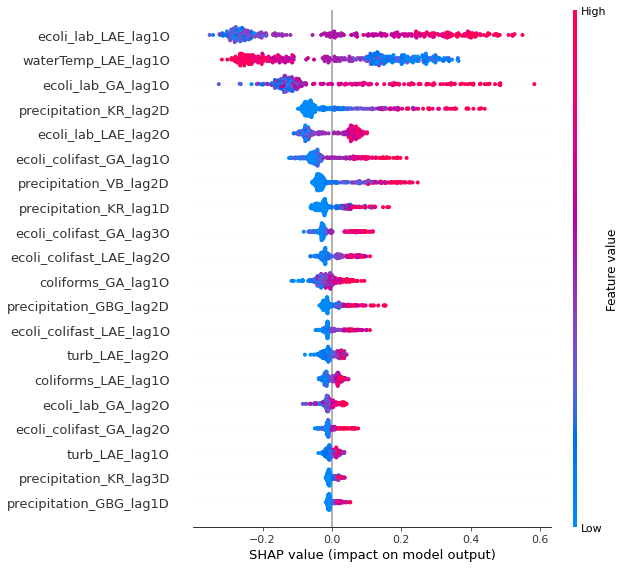

In [21]:
# Example of using SHAP values.

explainer = shap.TreeExplainer(rf_gs_cv.best_estimator_['model'].regressor_)

shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10,8), facecolor='w')
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=df_test.iloc[:, 1:].columns,
    show=False
)
plt.savefig(img_path + 'RF/shap_summary_plot.png', bbox_inches='tight', transparent=False)
plt.show()


In [22]:
shap.force_plot(
    explainer.expected_value,
    shap_values,
    X_test,
    feature_names=df_test.iloc[:, 1:].columns
)

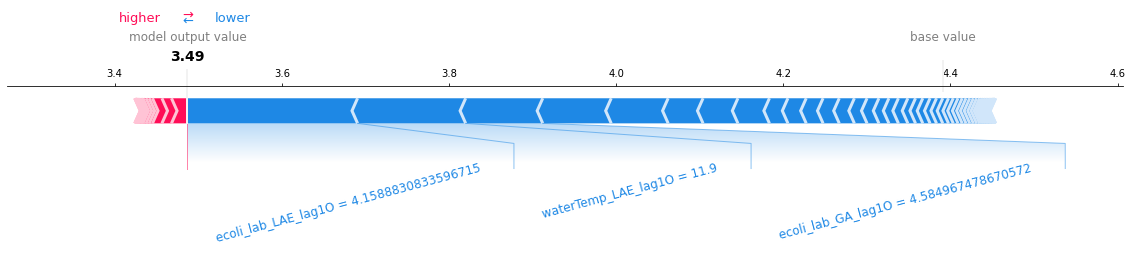

In [23]:
idx = 90
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_test[idx,:],
    feature_names=df_test.iloc[:, 1:].columns,
    matplotlib=True,
    text_rotation=15,
)